In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm import tqdm

def simulate_AR1(phi, mu, sigma, T):
    shocks = np.random.normal(0, sigma, T)
    y = np.zeros(T)
    y[0] = mu + shocks[0]
    for t in range(1, T):
        y[t] = mu + phi * (y[t-1] - mu) + shocks[t]
    return y

def log_likelihood(params, data):
    mu, phi, sigma = params
    T = len(data)
    errors = data[1:] - mu - phi * (data[:-1] - mu)
    log_lik = np.sum(np.exp(norm.logpdf(errors, scale=sigma)))
    return -log_lik  # Negative log likelihood for minimization

def estimate_parameters(data):
    initial_guess = [0, 0, 1]
    result = minimize(log_likelihood, initial_guess, args=(data,), bounds=[(-0.1, 0.1), (-0.9, 0.9), (0.2, 2)])
    return result.x, result.hess_inv  # Estimated parameters and inverse Hessian (for standard errors)

N = 10000  # Number of simulations
T = 10000  # Number of observations
v = 1000   # Plot every v iterations
true_params = []
est_params = []
std_errors = []

for p in tqdm(range(N)):
    phi = np.random.uniform(-0.7, 0.7)
    mu = np.random.uniform(-0.3, 0.3)
    sigma = np.random.uniform(0.2, 2)
    true_params.append((phi, mu, sigma))
    
    data = simulate_AR1(phi, mu, sigma, T)
    
    estimated, hess_inv = estimate_parameters(data)
    est_params.append(estimated)
    std_errors.append(np.sqrt(np.diag(hess_inv.todense())))
    
    if (p + 1) % v == 0:
        # Convert lists to NumPy arrays for easier manipulation
        true_params_np = np.array(true_params)
        est_params_np = np.array(est_params)
        std_errors_np = np.array(std_errors)

        # Calculate differences between estimated and true parameters
        param_diffs = est_params_np - true_params_np

        # Plot histograms
        fig, axes = plt.subplots(3, 2, figsize=(12, 9))
        param_names = ['phi', 'mu', 'sigma']

        for i in range(3):
            axes[i, 0].hist(param_diffs[:, i], bins=20, alpha=0.75, label=f'{param_names[i]} diffs')
            axes[i, 0].set_title(f'Estimated minus True {param_names[i]}')
            axes[i, 0].legend()

            axes[i, 1].hist(std_errors_np[:, i], bins=20, alpha=0.75, label=f'{param_names[i]} SE')
            axes[i, 1].set_title(f'Standard Error of {param_names[i]}')
            axes[i, 1].legend()

        plt.tight_layout()
        plt.savefig(f'Exp AR {p + 1} iteration.png')
        plt.close(fig)  # Close the figure to avoid display issues in some environments


100%|█████████████████████████████████████| 10000/10000 [03:49<00:00, 43.59it/s]


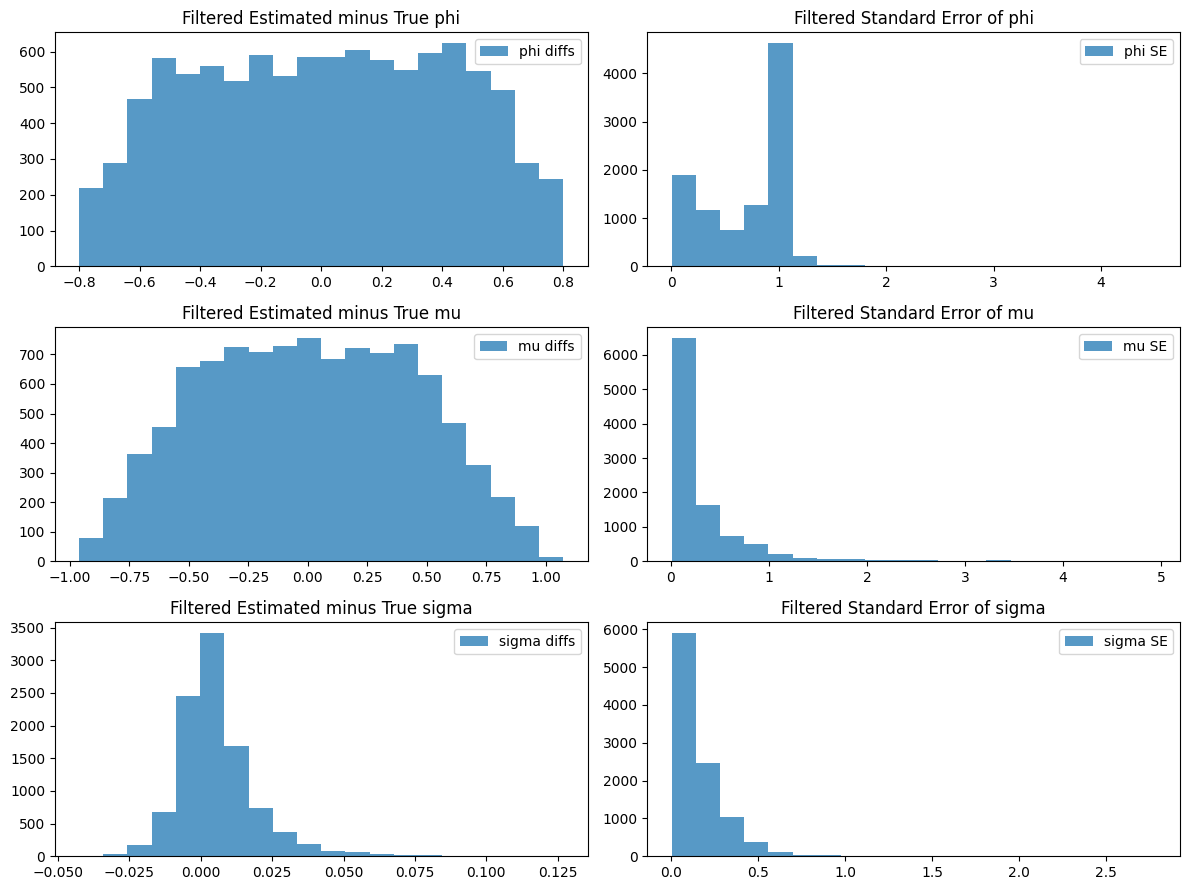

In [8]:
# Convert to numpy arrays for easier manipulation
true_params = np.array(true_params)
est_params = np.array(est_params)
std_errors = np.array(std_errors)

# Filter estimations with any standard error greater than 5
valid_indices = np.all(std_errors <= 5, axis=1)
filtered_est_params = est_params[valid_indices]
filtered_true_params = true_params[valid_indices]
filtered_std_errors = std_errors[valid_indices]

# Calculate differences between filtered estimated and true parameters
param_diffs = filtered_est_params - filtered_true_params

# Plot histograms for filtered results
fig, axes = plt.subplots(3, 2, figsize=(12, 9))
param_names = ['phi', 'mu', 'sigma']

for i in range(3):
    axes[i, 0].hist(param_diffs[:, i], bins=20, alpha=0.75, label=f'{param_names[i]} diffs')
    axes[i, 0].set_title(f'Filtered Estimated minus True {param_names[i]}')
    axes[i, 0].legend()

    axes[i, 1].hist(filtered_std_errors[:, i], bins=20, alpha=0.75, label=f'{param_names[i]} SE')
    axes[i, 1].set_title(f'Filtered Standard Error of {param_names[i]}')
    axes[i, 1].legend()
plt.savefig(f'FAR.png')
plt.tight_layout()
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.ar_model import AutoReg

def simulate_AR1(phi, mu, sigma, T):
    shocks = np.random.normal(0, sigma, T)
    y = np.zeros(T)
    y[0] = mu + shocks[0]
    for t in range(1, T):
        y[t] = mu + phi * (y[t-1] - mu) + shocks[t]
    return y

N = 10000  # Reduce for a demonstrative run
T = 10000  # Reduce for a demonstrative run
v = 1000   # Plot every v iterations for demonstration
true_params = []
mu_estimates = []
phi_estimates = []
mu_std_errors = [] 
phi_std_errors = []

for p in tqdm(range(N)):
    phi = np.random.uniform(-0.7, 0.7)
    mu = np.random.uniform(-0.3, 0.3)
    sigma = 1  # Fixed for simplification
    true_params.append((phi, mu))
    
    data = simulate_AR1(phi, mu, sigma, T)
    
    model = AutoReg(data, lags=1, trend='c')
    model_fitted = model.fit()
    mu_estimate = model_fitted.params[0]
    phi_estimate = model_fitted.params[1]
    mu_estimates.append(mu_estimate)
    phi_estimates.append(phi_estimate)
    
    mu_std_errors.append(model_fitted.bse[0])
    phi_std_errors.append(model_fitted.bse[1])
    
    if (p + 1) % v == 0 or p == N-1:
        true_params_np = np.array(true_params)
        mu_diffs = np.array(mu_estimates) - true_params_np[:, 1]
        phi_diffs = np.array(phi_estimates) - true_params_np[:, 0]

        # Plot histograms
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        axes[0, 0].hist(mu_diffs, bins=20, alpha=0.75, label='mu diffs')
        axes[0, 0].set_title('Estimated minus True mu')
        axes[0, 0].legend()

        axes[1, 0].hist(phi_diffs, bins=20, alpha=0.75, label='phi diffs')
        axes[1, 0].set_title('Estimated minus True phi')
        axes[1, 0].legend()

        axes[0, 1].hist(mu_std_errors, bins=20, alpha=0.75, label='mu SE')
        axes[0, 1].set_title('Standard Error of mu')
        axes[0, 1].legend()

        axes[1, 1].hist(phi_std_errors, bins=20, alpha=0.75, label='phi SE')
        axes[1, 1].set_title('Standard Error of phi')
        axes[1, 1].legend()

        plt.tight_layout()
        plt.savefig(f'2FAR {p + 1} iteration.png')
        plt.close(fig)  # Ensure the figure is closed after saving


100%|█████████████████████████████████████| 10000/10000 [05:53<00:00, 28.27it/s]


In [11]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

# Example simulated AR(1) process
np.random.seed(123)  # For reproducibility
T = 250
phi = 0.5
sigma = 1
mu = 0  # AutoReg does not directly estimate mu as part of AR parameters; it's included in the intercept
data = np.random.normal(0, sigma, T)
for t in range(1, T):
    data[t] = mu + phi * data[t-1] + np.random.normal(0, sigma)

# Fit the AR(1) model
model = AutoReg(data, lags=1)
model_fitted = model.fit()

# Access the estimated parameters
params = model_fitted.params
print("Estimated Parameters:", params)

# Access the standard errors of the estimates
std_errs = model_fitted.bse
print("Standard Errors:", std_errs)


Estimated Parameters: [-0.05499192  0.5107282 ]
Standard Errors: [0.06312314 0.05441139]
